In [32]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nikhilroxtomar/brain-tumor-segmentation")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-segmentation' dataset.
Path to dataset files: /kaggle/input/brain-tumor-segmentation


In [33]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu, threshold_sauvola

In [34]:
images_dir = os.path.join(path, "images")
masks_dir = os.path.join(path, "masks")

image_paths = sorted([
    os.path.join(images_dir, f)
    for f in os.listdir(images_dir)
    if f.endswith(".png")
])

mask_paths = sorted([
    os.path.join(masks_dir, f)
    for f in os.listdir(masks_dir)
    if f.endswith(".png")
])

len(image_paths), len(mask_paths)

(3064, 3064)

In [35]:
def preprocess_image(image):
    # Remove alpha channel if present
    if len(image.shape) == 3 and image.shape[2] == 4:
        image = image[:, :, :3]

    # Convert to grayscale
    if len(image.shape) == 3:
        image = rgb2gray(image)

    # Gaussian smoothing
    image = cv2.GaussianBlur(image, (5, 5), 0)
    return image

In [36]:
def otsu_segmentation(image):
    thresh = threshold_otsu(image)
    return image > thresh

In [37]:
def sauvola_segmentation(image, window_size=25):
    thresh = threshold_sauvola(image, window_size=window_size)
    return image > thresh

In [38]:
def dice_score(pred, gt):
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    intersection = np.logical_and(pred, gt).sum()
    return (2 * intersection) / (pred.sum() + gt.sum() + 1e-8)


In [39]:
def jaccard_index(pred, gt):
    pred = pred.astype(bool)
    gt = gt.astype(bool)
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return intersection / (union + 1e-8)

In [40]:
dice_otsu_list = []
jaccard_otsu_list = []

dice_sauvola_list = []
jaccard_sauvola_list = []

for img_path, mask_path in zip(image_paths, mask_paths):

    # Load image & mask
    image = preprocess_image(imread(img_path))
    gt_mask = imread(mask_path)

    # Convert GT mask to binary
    if len(gt_mask.shape) == 3:
        gt_mask = gt_mask[:, :, 0]
    gt_mask = gt_mask > 0

    # Segment
    otsu_mask = otsu_segmentation(image)
    sauvola_mask = sauvola_segmentation(image)

    # Metrics
    dice_otsu_list.append(dice_score(otsu_mask, gt_mask))
    jaccard_otsu_list.append(jaccard_index(otsu_mask, gt_mask))

    dice_sauvola_list.append(dice_score(sauvola_mask, gt_mask))
    jaccard_sauvola_list.append(jaccard_index(sauvola_mask, gt_mask))

In [41]:
avg_dice_otsu = np.mean(dice_otsu_list)
avg_jaccard_otsu = np.mean(jaccard_otsu_list)

avg_dice_sauvola = np.mean(dice_sauvola_list)
avg_jaccard_sauvola = np.mean(jaccard_sauvola_list)

avg_dice_otsu, avg_jaccard_otsu, avg_dice_sauvola, avg_jaccard_sauvola

(np.float64(0.07067737114884175),
 np.float64(0.037609681481357744),
 np.float64(0.04554502980126616),
 np.float64(0.023686189135635454))

In [42]:
import pandas as pd

results = pd.DataFrame({
    "Method": ["Otsu", "Sauvola"],
    "Average Dice Score": [avg_dice_otsu, avg_dice_sauvola],
    "Average Jaccard Index": [avg_jaccard_otsu, avg_jaccard_sauvola]
})

results

,Method,Average Dice Score,Average Jaccard Index
0,Otsu,0.070677,0.037610
1,Sauvola,0.045545,0.023686


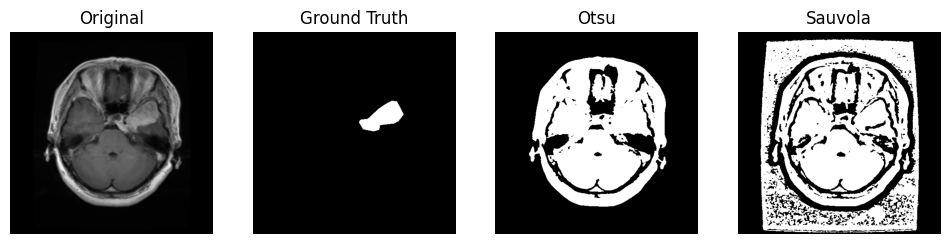

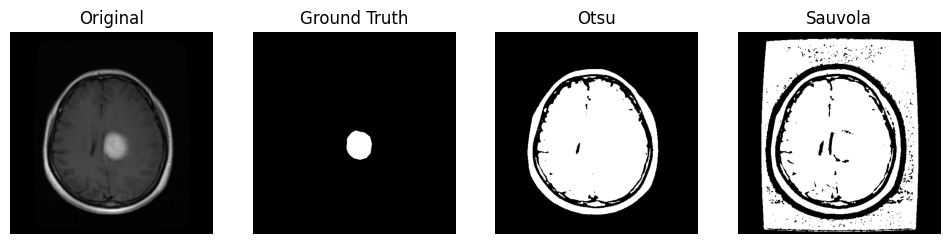

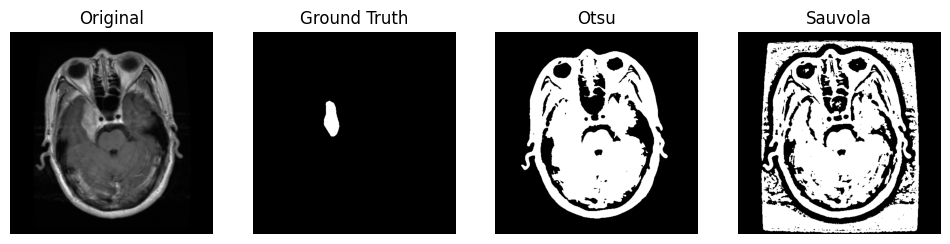

In [43]:
for i in range(3):
    image = preprocess_image(imread(image_paths[i]))
    gt_mask = imread(mask_paths[i]) > 0

    otsu = otsu_segmentation(image)
    sauvola = sauvola_segmentation(image)

    plt.figure(figsize=(12,3))

    plt.subplot(1,4,1)
    plt.title("Original")
    plt.imshow(image, cmap="gray")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.title("Ground Truth")
    plt.imshow(gt_mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.title("Otsu")
    plt.imshow(otsu, cmap="gray")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.title("Sauvola")
    plt.imshow(sauvola, cmap="gray")
    plt.axis("off")

    plt.show()

### Discussion on Low Dice and Jaccard Scores

The observed Dice and Jaccard scores for both Otsu and Sauvola thresholding methods are relatively low due to the complex nature of brain MRI images and the small size of tumor regions relative to the entire image. Brain tumors often exhibit low contrast with surrounding tissues, making intensity-based thresholding insufficient for accurate segmentation. Additionally, the ground truth masks are manually annotated with high precision, while thresholding methods produce coarse segmentation results. These factors collectively lead to reduced overlap metrics, highlighting the limitations of classical global and adaptive thresholding techniques in medical image segmentation tasks.